<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports and Plot Stylizations

In [4]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

In [2]:

def getStockData(ticker: str, startYear: str, endYear: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=5y&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

def toDatetime(t):
  return datetime.fromtimestamp(t)


# Plotting AAPL close prices to visualize

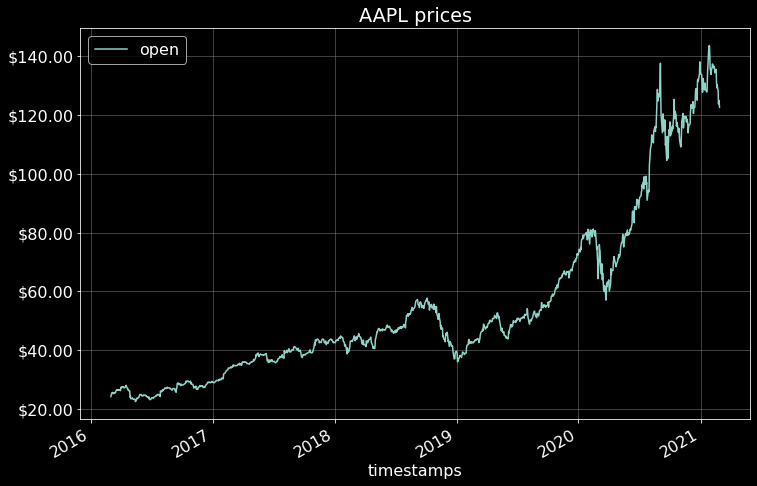

In [5]:
ticker = 'AAPL'
df = getStockData(ticker, "2017", "2020")

ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Method for labeling price data as BUY, HOLD, or SELL

*SELL = 0, BUY = 1, HOLD = 2*


*Parameters:*

    df: Pandas DataFrame
    col_name: Name of the column in df that will be used to determine labels
        - availiable names: "open", "close", "high", "low"
    window_size: How large the window size will be when determining labels
        - default size: 11

In [6]:
from tqdm.auto import tqdm

def create_labels(df, col_name, window_size=11):

    row_counter = 0
    total_rows = len(df)
    # Creates a 1 x N numpy array
    labels = np.zeros(total_rows)
    # Makes all the entries in labels array equal to nan
    labels[:] = np.nan
    # Sets up a progress bar
    pbar = tqdm(total=total_rows)

    while row_counter < total_rows:

        # Stalls labeling calculation until the row_counter is at least as big as the window_size
        if row_counter >= window_size - 1:
            window_begin = row_counter - (window_size - 1)
            window_end = row_counter
            window_middle = (window_begin + window_end) // 2 # Cast as int

            min_ = np.inf
            min_index = -1
            max_ = -np.inf
            max_index = -1
            for i in range(window_begin, window_end + 1):
                # Selected value at 'i' index in column with name equal to col_name variable
                price = df.iloc[i][col_name]
                if price < min_:
                    # Finds the smallest value in the window
                    # 'min_' is initially set to infinity
                    min_ = price
                    # Saves the index of the lowest value
                    min_index = i
                if price > max_:
                    # Finds the largest value in the window
                    # 'max_' is initially set to -infinity
                    max_ = price
                    # Saves the index of the largest value
                    max_index = i

            if max_index == window_middle:
                # Sets label to SELL
                labels[window_middle] = 0
            elif min_index == window_middle:
                # Sets label to BUY
                labels[window_middle] = 1
            else:
                # Sets label to HOLD
                labels[window_middle] = 2

        row_counter = row_counter + 1
        pbar.update(1)


    pbar.close()
    return labels

# Plotting of prediction labels using 'close' column

Text(0.5, 1.0, 'Prediction Labels')

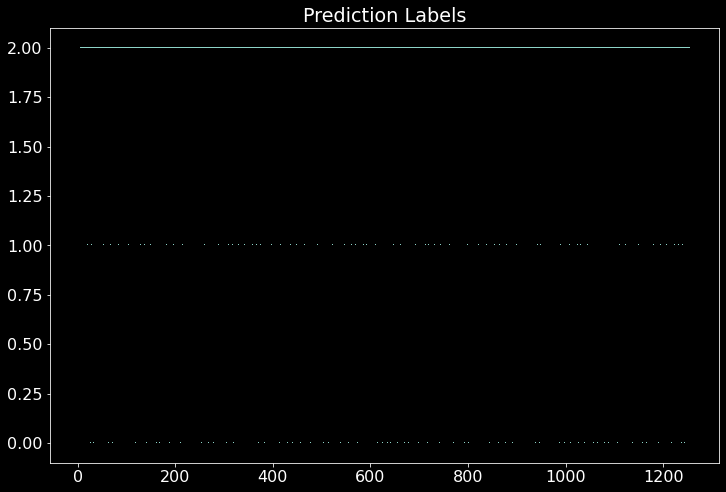

In [7]:
labels = create_labels(df, 'close')

fig = plt.figure()
plt.plot(labels, ',')
plt.title('Prediction Labels')

# Technical Indicator methods


***Technical Indicators Used:***

*   MACD
*   RSI
*   %K
*   %D
*   ATR
*   DEMA
*   BB
*   WR









<Figure size 864x576 with 0 Axes>

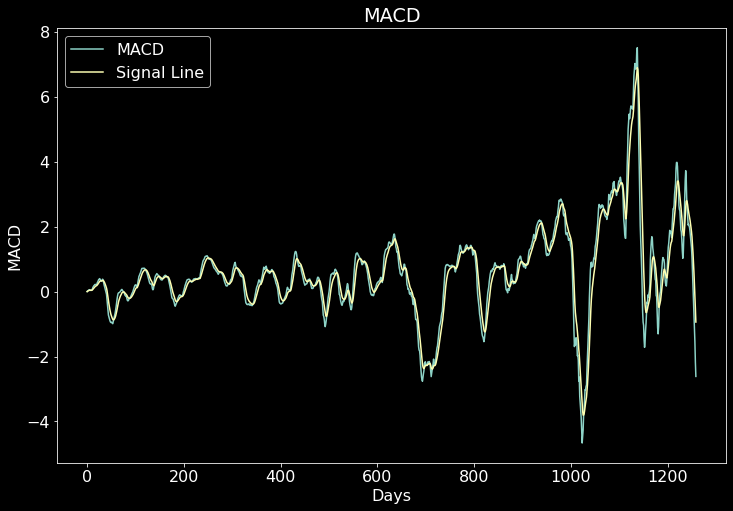

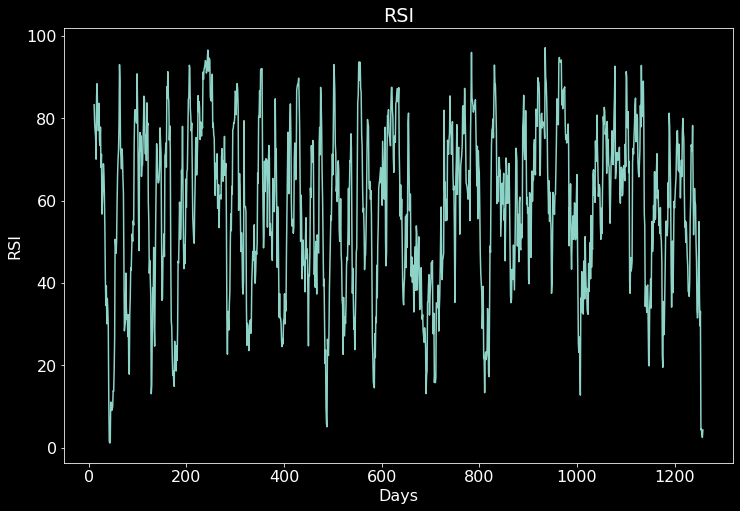

In [20]:
# MACD: Moving Average Convergance Diverage Momentum
def calculate_macd(df):
    # MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.
    # The speed of crossovers is also taken as a signal of a market is overbought or oversold.
    # MACD helps investors understand whether the bullish or bearish movement in the price is strengthening or weakening.
    df['MACD'] = df["close"].ewm(span=12).mean() - df["close"].ewm(span=26).mean()
    df['Signal Line'] = df['MACD'].ewm(span=9).mean()


# RSI: Relative Strength Index 
def calculate_rsi(df):
    # Signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset's price
    # An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%
    # A momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset
    # The RSI is displayed as an oscillator and can have a reading from 0 to 100.
    diff = df['close'].diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    down = abs(down)
    elevenDayUpCloses = up.rolling(11).mean() # using 11 day periods
    elevenDayDownCloses = down.rolling(11).mean() # using 11 day periods
    relative_strength = elevenDayUpCloses / elevenDayDownCloses
    df['RSI'] = 100 - (100/(1+relative_strength))


calculate_macd(df)
calculate_rsi(df)

def plot_indicators(df, columns, yTitle, xTitle):
    plt.figure()
    ax = df[columns].plot(title=yTitle)
    ax.set_xlabel(xTitle)
    ax.set_ylabel(yTitle)
   

plot_indicators(df, ['MACD', "Signal Line"], "MACD", "Days")
plot_indicators(df, "RSI", "RSI", "Days")